In [ ]:
# ============================================================================== 
# 0. Setup Kaggle and Download Dataset (Windows)
# ============================================================================== 
import os
import zipfile

# Path to your kaggle.json file
KAGGLE_JSON_PATH = r"C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capstone Project\kaggle.json"

# Make .kaggle folder in your user directory if it doesn't exist
KAGGLE_DIR = os.path.join(os.path.expanduser("~"), ".kaggle")
os.makedirs(KAGGLE_DIR, exist_ok=True)

# Copy kaggle.json to .kaggle folder
import shutil
shutil.copy(KAGGLE_JSON_PATH, os.path.join(KAGGLE_DIR, "kaggle.json"))

# Set permissions (optional on Windows, but safe)
os.chmod(os.path.join(KAGGLE_DIR, "kaggle.json"), 0o600)

# Create dataset folder
DATA_DIR = r"C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capstone Project\data\cbis_ddsm"
os.makedirs(DATA_DIR, exist_ok=True)

# Download the dataset using Kaggle CLI
os.system(f'kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset -p "{DATA_DIR}" --force')

# Unzip the dataset
zip_path = os.path.join(DATA_DIR, "cbis-ddsm-breast-cancer-image-dataset.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

print("Dataset downloaded and extracted successfully!")

In [16]:
# A Technical Implementation of MV-Swin-T for Multi-View Mammogram Classification
# ==============================================================================
# This notebook provides a complete, end-to-end implementation of the
# MV-Swin-T architecture, translating the concepts from the research paper
# into a functional PyTorch model.

# ==============================================================================
# 1. Environment Setup and Data Preparation
# ==============================================================================

# 1.1. Imports and Configuration
import os
import re
import glob
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- Configuration ---
class Config:
    CSV_PATH = r"C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capstone Project\data\cbis_ddsm\csv"
    IMAGE_PATH = r"C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capstone Project\data\cbis_ddsm\jpeg"

    # Model Hyperparameters
    IMG_SIZE = 384
    BATCH_SIZE = 4
    EPOCHS = 100 # Reduced for demonstration; paper uses 100
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.001

    # Swin Transformer specific (Swin-T configuration)
    EMBED_DIM = 96
    DEPTHS = [2, 2, 6, 2]
    NUM_HEADS = [3, 6, 12, 24] # Corrected: Filled in standard Swin-T heads
    WINDOW_SIZE = 12

    # Training settings
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42
    NUM_WORKERS = 0
    PIN_MEMORY = True
    EARLY_STOPPING_PATIENCE = 10


config = Config()

# --- Reproducibility ---
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(config.SEED)
print(f"Using device: {config.DEVICE}")

Using device: cuda


In [17]:
# ==============================================================================
# 1.2. FINAL CORRECTED: Data Loading and Path Mapping
# ==============================================================================
# The debug output revealed the CSV paths contain TWO UID-like strings.
# This final version correctly extracts the SECOND (and last) one, which
# corresponds to the actual folder containing the JPEG images.

# Load metadata CSVs
mass_df = pd.read_csv(os.path.join(config.CSV_PATH, 'mass_case_description_train_set.csv'))
calc_df = pd.read_csv(os.path.join(config.CSV_PATH, 'calc_case_description_train_set.csv'))
full_df = pd.concat([mass_df, calc_df], ignore_index=True)

# Create simplified patient ID and a unique ID for each breast
def extract_simple_patient_id(pid):
    parts = pid.split('_')
    for i, part in enumerate(parts):
        if part == 'P':
            return f"{part}_{parts[i+1]}"
    return pid

full_df['simple_patient_id'] = full_df['patient_id'].apply(extract_simple_patient_id)
full_df['patient_breast_id'] = full_df['simple_patient_id'] + '_' + full_df['left or right breast']
full_df['label'] = full_df['pathology'].apply(lambda x: 1 if 'MALIGNANT' in x.upper() else 0)

# --- Function to map CSV paths to actual JPEG paths on disk ---
def find_jpeg_path(csv_path_series):
    jpeg_paths = []
    for csv_path in tqdm(csv_path_series, desc="Mapping CSV to JPEG paths"):
        # *** FIX: Find all UID-like parts and take the LAST one. ***
        uid_parts = [part for part in csv_path.split('/') if part.startswith('1.3.6.')]

        if uid_parts:
            # The correct folder is the last UID in the path string
            dicom_uid_folder = uid_parts[-1]
            search_pattern = os.path.join(config.IMAGE_PATH, dicom_uid_folder, '*.jpg')
            found_files = glob.glob(search_pattern)
            jpeg_paths.append(found_files[0] if found_files else None)
        else:
            jpeg_paths.append(None)

    return jpeg_paths

# Apply the mapping function
full_df['jpeg_path'] = find_jpeg_path(full_df['image file path'])

# Remove rows where no corresponding JPEG file was found
original_rows = len(full_df)
full_df.dropna(subset=['jpeg_path'], inplace=True)
print(f"\nSuccessfully mapped {len(full_df)} of {original_rows} CSV entries to JPEG files.")

# --- Ipsilateral View Pairing Algorithm ---
paired_data = []
grouped = full_df.groupby('patient_breast_id')

for name, group in tqdm(grouped, desc="Pairing CC and MLO views"):
    cc_view = group[group['image view'] == 'CC']
    mlo_view = group[group['image view'] == 'MLO']

    if not cc_view.empty and not mlo_view.empty:
        for _, cc_row in cc_view.iterrows():
            for _, mlo_row in mlo_view.iterrows():
                paired_data.append({
                    'patient_breast_id': name,
                    'cc_path': cc_row['jpeg_path'],
                    'mlo_path': mlo_row['jpeg_path'],
                    'label': cc_row['label']
                })

paired_df = pd.DataFrame(paired_data)
print(f"\nSuccessfully created {len(paired_df)} CC/MLO pairs.")
print("\nSample of Paired DataFrame:")
print(paired_df.head())

Mapping CSV to JPEG paths: 100%|██████████| 2864/2864 [00:00<00:00, 3124.55it/s]



Successfully mapped 2864 of 2864 CSV entries to JPEG files.


Pairing CC and MLO views: 100%|██████████| 1358/1358 [00:00<00:00, 1812.50it/s]


Successfully created 1956 CC/MLO pairs.

Sample of Paired DataFrame:
  patient_breast_id                                            cc_path  \
0      P_00001_LEFT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   
1      P_00004_LEFT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   
2     P_00005_RIGHT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   
3      P_00007_LEFT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   
4      P_00008_LEFT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   

                                            mlo_path  label  
0  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      1  
1  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      0  
2  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      1  
3  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      0  
4  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      0  


In [18]:
# ==============================================================================
# 2. CBIS-DDSM Multi-View Dataloader
# ==============================================================================

# 2.1. Custom PyTorch Dataset
class CBISDDSMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load images from actual paths
        cc_image = cv2.imread(row['cc_path'], cv2.IMREAD_GRAYSCALE)
        mlo_image = cv2.imread(row['mlo_path'], cv2.IMREAD_GRAYSCALE)

        # --- Preprocessing and Enhancement ---
        # Convert to 3 channels for standard models
        cc_image = cv2.cvtColor(cc_image, cv2.COLOR_GRAY2RGB)
        mlo_image = cv2.cvtColor(mlo_image, cv2.COLOR_GRAY2RGB)

        # Apply CLAHE for contrast enhancement on each channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        for i in range(3):
            cc_image[:, :, i] = clahe.apply(cc_image[:, :, i])
            mlo_image[:, :, i] = clahe.apply(mlo_image[:, :, i])

        label = torch.tensor(row['label'], dtype=torch.float32)

        if self.transform:
            cc_augmented = self.transform(image=cc_image)['image']
            mlo_augmented = self.transform(image=mlo_image)['image']

        return {
            'cc_view': cc_augmented,
            'mlo_view': mlo_augmented,
            'label': label.unsqueeze(0)
        }

# 2.2. Data Augmentations
# Define augmentations as specified in the paper (flips, rotation)
train_transform = A.Compose([
    A.Resize(config.IMG_SIZE, config.IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(config.IMG_SIZE, config.IMG_SIZE),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2(),
])

In [19]:
# 2.3. DataLoaders Instantiation
train_df, val_df = train_test_split(paired_df, test_size=0.2, random_state=config.SEED, stratify=paired_df['label'])

train_dataset = CBISDDSMDataset(train_df, transform=train_transform)
val_dataset = CBISDDSMDataset(val_df, transform=val_transform)

train_loader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
    num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY
)
val_loader = DataLoader(
    val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY
)

print(f"\nTrain loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")


Train loader batches: 391
Validation loader batches: 98


In [ ]:
# ==============================================================================
# 3. Core Architectural Components of MV-Swin-T 
# ==============================================================================

# --- 3.1. Shared Utilities ---
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        return self.drop(self.fc2(self.drop(self.act(self.fc1(x)))))

def window_partition(x, window_size):
    B, H, W, C = x.shape
    window_size = min(window_size, H, W)  # ✅ Prevents invalid reshape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    return x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size * window_size, C)


def window_reverse(windows, window_size, H, W):
    window_size = min(window_size, H, W)  # ✅ match partition
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    return x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return self.norm(x)

class PatchMerging(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(4 * dim)

    def forward(self, x, H, W):
        B, L, C = x.shape
        x = x.view(B, H, W, C)
        x = torch.cat([
            x[:, 0::2, 0::2, :], x[:, 1::2, 0::2, :],
            x[:, 0::2, 1::2, :], x[:, 1::2, 1::2, :]
        ], -1)
        x = x.view(B, -1, 4 * C)
        x = self.norm(x)
        return self.reduction(x)

In [21]:
# --- 3.2. Multi-Head Dynamic Attention (MDA) ---
class MultiHeadDynamicAttention(nn.Module):
    def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x_origin, x_cross):
        B_, N, C = x_origin.shape
        q = self.q(x_origin).reshape(B_, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.k(x_cross).reshape(B_, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.v(x_origin).reshape(B_, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        return self.proj(x)

In [22]:
# --- 3.3. Omni-Attention Transformer Block ---
class OmniAttentionTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size=0, mlp_ratio=4.):
        super().__init__()
        self.window_size = window_size
        self.shift_size = shift_size

        self.norm1_cc = nn.LayerNorm(dim)
        self.norm1_mlo = nn.LayerNorm(dim)
        self.attn = MultiHeadDynamicAttention(dim, num_heads, window_size)

        self.norm2_cc = nn.LayerNorm(dim)
        self.norm2_mlo = nn.LayerNorm(dim)
        self.mlp_cc = Mlp(dim, int(dim * mlp_ratio), act_layer=nn.ReLU)
        self.mlp_mlo = Mlp(dim, int(dim * mlp_ratio), act_layer=nn.ReLU)

    def forward(self, x_cc, x_mlo, H, W):
        B, L, C = x_cc.shape
        shortcut_cc, shortcut_mlo = x_cc, x_mlo

        x_cc, x_mlo = self.norm1_cc(x_cc).view(B, H, W, C), self.norm1_mlo(x_mlo).view(B, H, W, C)

        if self.shift_size > 0:
            shifted_x_cc = torch.roll(x_cc, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            shifted_x_mlo = torch.roll(x_mlo, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x_cc, shifted_x_mlo = x_cc, x_mlo

        x_windows_cc = window_partition(shifted_x_cc, self.window_size)
        x_windows_mlo = window_partition(shifted_x_mlo, self.window_size)

        attn_windows_cc = self.attn(x_windows_cc, x_windows_mlo)
        attn_windows_mlo = self.attn(x_windows_mlo, x_windows_cc)

        shifted_x_cc = window_reverse(attn_windows_cc, self.window_size, H, W)
        shifted_x_mlo = window_reverse(attn_windows_mlo, self.window_size, H, W)

        if self.shift_size > 0:
            x_cc = torch.roll(shifted_x_cc, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
            x_mlo = torch.roll(shifted_x_mlo, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x_cc, x_mlo = shifted_x_cc, shifted_x_mlo

        x_cc, x_mlo = x_cc.view(B, L, C), x_mlo.view(B, L, C)
        x_cc = shortcut_cc + x_cc
        x_mlo = shortcut_mlo + x_mlo

        x_cc = x_cc + self.mlp_cc(self.norm2_cc(x_cc))
        x_mlo = x_mlo + self.mlp_mlo(self.norm2_mlo(x_mlo))
        return x_cc, x_mlo

In [23]:
# --- 3.4. Standard Swin Transformer Block (for shared stages) ---
class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        return self.proj(x)

class StandardSwinBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size=0, mlp_ratio=4.):
        super().__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, num_heads, window_size)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp(dim, int(dim * mlp_ratio))

    def forward(self, x, H, W):
        B, L, C = x.shape
        shortcut = x
        x = self.norm1(x).view(B, H, W, C)

        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        attn_windows = self.attn(x_windows)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(B, L, C)
        x = shortcut + x
        x = x + self.mlp(self.norm2(x))
        return x

In [24]:
# --- 3.5. CNN FrontEnd ---

class CNNFrontEnd(nn.Module):
    def __init__(self, in_chans=3, out_chans=32):
        super().__init__()
        self.out_chans = out_chans
        self.conv1 = nn.Conv2d(in_chans, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, out_chans, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(out_chans)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        return x


In [25]:
# --- 3.6. Hybrid MV-Swin-T Model ---

class MVSwinT(nn.Module):
    def __init__(self, img_size=384, patch_size=4, in_chans=3, num_classes=1,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=12, mlp_ratio=4., norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.patch_size = patch_size

        # --- CNN front-ends for CC and MLO ---
        self.cnn_downsample = 4
        self.cnn_out_channels = 32
        self.cnn_frontend_cc = CNNFrontEnd(in_chans=in_chans, out_chans=self.cnn_out_channels)
        self.cnn_frontend_mlo = CNNFrontEnd(in_chans=in_chans, out_chans=self.cnn_out_channels)

        # --- Patch embedding after CNN ---
        new_img_size = img_size // self.cnn_downsample
        self.patches_resolution = [new_img_size // patch_size, new_img_size // patch_size]
        self.patch_embed_cc = PatchEmbed(new_img_size, patch_size, in_chans=self.cnn_out_channels, embed_dim=embed_dim)
        self.patch_embed_mlo = PatchEmbed(new_img_size, patch_size, in_chans=self.cnn_out_channels, embed_dim=embed_dim)

        # --- Stage 1 & 2 (Omni-Attention) ---
        self.stage1 = self.build_stage(embed_dim, depths[0], num_heads[0], window_size, mlp_ratio, is_omni=True)
        self.patch_merge1_cc, self.patch_merge1_mlo = PatchMerging(embed_dim), PatchMerging(embed_dim)
        self.stage2 = self.build_stage(embed_dim*2, depths[1], num_heads[1], window_size, mlp_ratio, is_omni=True)

        # --- Fusion ---
        self.fusion_norm = norm_layer(embed_dim * 4)
        self.fusion_linear = nn.Linear(embed_dim * 4, embed_dim * 2)

        # --- Stage 3 & 4 (Shared Swin) ---
        self.patch_merge2 = PatchMerging(embed_dim * 2)
        self.stage3 = self.build_stage(embed_dim*4, depths[2], num_heads[2], window_size, mlp_ratio, is_omni=False)
        self.patch_merge3 = PatchMerging(embed_dim * 4)
        self.stage4 = self.build_stage(embed_dim*8, depths[3], num_heads[3], window_size, mlp_ratio, is_omni=False)

        # --- Classifier ---
        self.norm = norm_layer(embed_dim * 8)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(embed_dim * 8, num_classes)

    def build_stage(self, dim, depth, num_heads, window_size, mlp_ratio, is_omni):
        block_class = OmniAttentionTransformerBlock if is_omni else StandardSwinBlock
        return nn.ModuleList([
            block_class(dim, num_heads, window_size, shift_size=(0 if i % 2 == 0 else window_size // 2), mlp_ratio=mlp_ratio)
            for i in range(depth)
        ])

    def forward(self, x_cc, x_mlo):
        # --- CNN Front-End ---
        x_cc = self.cnn_frontend_cc(x_cc)
        x_mlo = self.cnn_frontend_mlo(x_mlo)

        # --- Patch Embedding ---
        x_cc, x_mlo = self.patch_embed_cc(x_cc), self.patch_embed_mlo(x_mlo)
        H, W = self.patches_resolution

        # --- Stage 1 ---
        for blk in self.stage1:
            x_cc, x_mlo = blk(x_cc, x_mlo, H, W)
        x_cc, x_mlo = self.patch_merge1_cc(x_cc, H, W), self.patch_merge1_mlo(x_mlo, H, W)
        H, W = H//2, W//2

        # --- Stage 2 ---
        for blk in self.stage2:
            x_cc, x_mlo = blk(x_cc, x_mlo, H, W)

        # --- Fusion ---
        x = torch.cat([x_cc, x_mlo], dim=2)
        x = self.fusion_linear(self.fusion_norm(x))

        # --- Stage 3 ---
        x = self.patch_merge2(x, H, W)
        H, W = H//2, W//2
        for blk in self.stage3:
            x = blk(x, H, W)

        # --- Stage 4 ---
        x = self.patch_merge3(x, H, W)
        H, W = H//2, W//2
        for blk in self.stage4:
            x = blk(x, H, W)

        # --- Classification ---
        x = self.norm(x)
        x = self.avgpool(x.transpose(1, 2))
        return self.head(torch.flatten(x, 1))


In [26]:
# ==============================================================================
# 4. Training Configuration and Execution
# ==============================================================================

# 4.1. Instantiating the Model and Utilities
model = MVSwinT(
    img_size=config.IMG_SIZE,
    patch_size=config.PATCH_SIZE if hasattr(config, "PATCH_SIZE") else 4,
    in_chans=3,
    embed_dim=config.EMBED_DIM,
    depths=config.DEPTHS,
    num_heads=config.NUM_HEADS,
    window_size=config.WINDOW_SIZE
).to(config.DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

print(f"\nModel has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")



Model has 28,558,657 trainable parameters.


In [27]:
# 4.2. Training and Validation Functions
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc="Training"):
        cc_view, mlo_view, labels = batch['cc_view'].to(device), batch['mlo_view'].to(device), batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(cc_view, mlo_view)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(labels.cpu())

    preds = torch.cat(all_preds).numpy()
    labels = torch.cat(all_labels).numpy()
    return total_loss / len(loader), roc_auc_score(labels, preds)

def validate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            cc_view, mlo_view, labels = batch['cc_view'].to(device), batch['mlo_view'].to(device), batch['label'].to(device)
            outputs = model(cc_view, mlo_view)
            total_loss += loss_fn(outputs, labels).item()
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    preds = torch.cat(all_preds).numpy()
    labels = torch.cat(all_labels).numpy()
    return total_loss / len(loader), roc_auc_score(labels, preds)

In [28]:
# 4.3. The Main Training Loop
history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(config.EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{config.EPOCHS} ---")

    train_loss, train_auc = train_one_epoch(model, train_loader, optimizer, loss_fn, config.DEVICE)
    val_loss, val_auc = validate(model, val_loader, loss_fn, config.DEVICE)

    print(f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_auc'].append(train_auc)
    history['val_auc'].append(val_auc)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'mv_swin_t_best_model.pth')
        print("Validation loss improved. Model saved.")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{config.EARLY_STOPPING_PATIENCE}")

    if patience_counter >= config.EARLY_STOPPING_PATIENCE:
        print("Early stopping triggered.")
        break


--- Epoch 1/100 ---


Validating: 100%|██████████| 98/98 [02:13<00:00,  1.36s/it]


Train Loss: 0.6862, Train AUC: 0.5099
Val Loss: 0.6520, Val AUC: 0.6047
Validation loss improved. Model saved.

--- Epoch 2/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.35s/it]


Train Loss: 0.6550, Train AUC: 0.4808
Val Loss: 0.6265, Val AUC: 0.6930
Validation loss improved. Model saved.

--- Epoch 3/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.6417, Train AUC: 0.4843
Val Loss: 0.6389, Val AUC: 0.7370
Validation loss did not improve. Patience: 1/10

--- Epoch 4/100 ---


Validating: 100%|██████████| 98/98 [02:14<00:00,  1.37s/it]


Train Loss: 0.6445, Train AUC: 0.5040
Val Loss: 0.6233, Val AUC: 0.7320
Validation loss improved. Model saved.

--- Epoch 5/100 ---


Validating: 100%|██████████| 98/98 [02:13<00:00,  1.36s/it]


Train Loss: 0.6402, Train AUC: 0.4993
Val Loss: 0.6427, Val AUC: 0.7116
Validation loss did not improve. Patience: 1/10

--- Epoch 6/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.6393, Train AUC: 0.4948
Val Loss: 0.6558, Val AUC: 0.7138
Validation loss did not improve. Patience: 2/10

--- Epoch 7/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.6390, Train AUC: 0.4729
Val Loss: 0.6259, Val AUC: 0.7190
Validation loss did not improve. Patience: 3/10

--- Epoch 8/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.36s/it]


Train Loss: 0.6320, Train AUC: 0.5068
Val Loss: 0.6300, Val AUC: 0.7199
Validation loss did not improve. Patience: 4/10

--- Epoch 9/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.6382, Train AUC: 0.4938
Val Loss: 0.6272, Val AUC: 0.7204
Validation loss did not improve. Patience: 5/10

--- Epoch 10/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.6343, Train AUC: 0.4898
Val Loss: 0.6336, Val AUC: 0.7257
Validation loss did not improve. Patience: 6/10

--- Epoch 11/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.6289, Train AUC: 0.4795
Val Loss: 0.6247, Val AUC: 0.7253
Validation loss did not improve. Patience: 7/10

--- Epoch 12/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.35s/it]


Train Loss: 0.6268, Train AUC: 0.5061
Val Loss: 0.6241, Val AUC: 0.7266
Validation loss did not improve. Patience: 8/10

--- Epoch 13/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.6267, Train AUC: 0.5050
Val Loss: 0.6239, Val AUC: 0.7318
Validation loss did not improve. Patience: 9/10

--- Epoch 14/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.6257, Train AUC: 0.5326
Val Loss: 0.6166, Val AUC: 0.7322
Validation loss improved. Model saved.

--- Epoch 15/100 ---


Validating: 100%|██████████| 98/98 [03:59<00:00,  2.44s/it]


Train Loss: 0.6265, Train AUC: 0.5780
Val Loss: 0.5944, Val AUC: 0.7357
Validation loss improved. Model saved.

--- Epoch 16/100 ---


Validating: 100%|██████████| 98/98 [03:58<00:00,  2.43s/it]


Train Loss: 0.5987, Train AUC: 0.6400
Val Loss: 0.5595, Val AUC: 0.7381
Validation loss improved. Model saved.

--- Epoch 17/100 ---


Validating: 100%|██████████| 98/98 [02:10<00:00,  1.33s/it]


Train Loss: 0.5895, Train AUC: 0.6767
Val Loss: 0.5595, Val AUC: 0.7418
Validation loss improved. Model saved.

--- Epoch 18/100 ---


Validating: 100%|██████████| 98/98 [02:09<00:00,  1.32s/it]


Train Loss: 0.5884, Train AUC: 0.6745
Val Loss: 0.5527, Val AUC: 0.7404
Validation loss improved. Model saved.

--- Epoch 19/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.5796, Train AUC: 0.6963
Val Loss: 0.5476, Val AUC: 0.7468
Validation loss improved. Model saved.

--- Epoch 20/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.5775, Train AUC: 0.6920
Val Loss: 0.5382, Val AUC: 0.7501
Validation loss improved. Model saved.

--- Epoch 21/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.35s/it]


Train Loss: 0.5710, Train AUC: 0.7098
Val Loss: 0.5469, Val AUC: 0.7481
Validation loss did not improve. Patience: 1/10

--- Epoch 22/100 ---


Validating: 100%|██████████| 98/98 [02:14<00:00,  1.37s/it]


Train Loss: 0.5626, Train AUC: 0.7180
Val Loss: 0.5440, Val AUC: 0.7429
Validation loss did not improve. Patience: 2/10

--- Epoch 23/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.5679, Train AUC: 0.7079
Val Loss: 0.5368, Val AUC: 0.7478
Validation loss improved. Model saved.

--- Epoch 24/100 ---


Validating: 100%|██████████| 98/98 [02:08<00:00,  1.31s/it]


Train Loss: 0.5705, Train AUC: 0.7070
Val Loss: 0.5287, Val AUC: 0.7633
Validation loss improved. Model saved.

--- Epoch 25/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.5551, Train AUC: 0.7295
Val Loss: 0.5430, Val AUC: 0.7492
Validation loss did not improve. Patience: 1/10

--- Epoch 26/100 ---


Validating: 100%|██████████| 98/98 [02:15<00:00,  1.38s/it]


Train Loss: 0.5530, Train AUC: 0.7313
Val Loss: 0.5260, Val AUC: 0.7661
Validation loss improved. Model saved.

--- Epoch 27/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.5519, Train AUC: 0.7332
Val Loss: 0.5230, Val AUC: 0.7696
Validation loss improved. Model saved.

--- Epoch 28/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.5535, Train AUC: 0.7333
Val Loss: 0.5250, Val AUC: 0.7703
Validation loss did not improve. Patience: 1/10

--- Epoch 29/100 ---


Validating: 100%|██████████| 98/98 [02:10<00:00,  1.33s/it]


Train Loss: 0.5365, Train AUC: 0.7553
Val Loss: 0.5136, Val AUC: 0.7803
Validation loss improved. Model saved.

--- Epoch 30/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.5418, Train AUC: 0.7507
Val Loss: 0.5141, Val AUC: 0.7801
Validation loss did not improve. Patience: 1/10

--- Epoch 31/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.5425, Train AUC: 0.7498
Val Loss: 0.5080, Val AUC: 0.7870
Validation loss improved. Model saved.

--- Epoch 32/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.5372, Train AUC: 0.7547
Val Loss: 0.5084, Val AUC: 0.7866
Validation loss did not improve. Patience: 1/10

--- Epoch 33/100 ---


Validating: 100%|██████████| 98/98 [04:01<00:00,  2.46s/it]


Train Loss: 0.5219, Train AUC: 0.7713
Val Loss: 0.5117, Val AUC: 0.7819
Validation loss did not improve. Patience: 2/10

--- Epoch 34/100 ---


Validating: 100%|██████████| 98/98 [03:59<00:00,  2.44s/it]


Train Loss: 0.5183, Train AUC: 0.7744
Val Loss: 0.5031, Val AUC: 0.7919
Validation loss improved. Model saved.

--- Epoch 35/100 ---


Validating: 100%|██████████| 98/98 [02:07<00:00,  1.30s/it]


Train Loss: 0.5069, Train AUC: 0.7887
Val Loss: 0.5029, Val AUC: 0.7911
Validation loss improved. Model saved.

--- Epoch 36/100 ---


Validating: 100%|██████████| 98/98 [02:28<00:00,  1.51s/it]


Train Loss: 0.5140, Train AUC: 0.7804
Val Loss: 0.5053, Val AUC: 0.7900
Validation loss did not improve. Patience: 1/10

--- Epoch 37/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.35s/it]


Train Loss: 0.5064, Train AUC: 0.7897
Val Loss: 0.4971, Val AUC: 0.8031
Validation loss improved. Model saved.

--- Epoch 38/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.5123, Train AUC: 0.7833
Val Loss: 0.4789, Val AUC: 0.8119
Validation loss improved. Model saved.

--- Epoch 39/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.35s/it]


Train Loss: 0.4879, Train AUC: 0.8057
Val Loss: 0.5039, Val AUC: 0.7934
Validation loss did not improve. Patience: 1/10

--- Epoch 40/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4824, Train AUC: 0.8106
Val Loss: 0.4955, Val AUC: 0.8012
Validation loss did not improve. Patience: 2/10

--- Epoch 41/100 ---


Validating: 100%|██████████| 98/98 [02:07<00:00,  1.30s/it]


Train Loss: 0.4886, Train AUC: 0.8027
Val Loss: 0.4839, Val AUC: 0.8038
Validation loss did not improve. Patience: 3/10

--- Epoch 42/100 ---


Validating: 100%|██████████| 98/98 [02:07<00:00,  1.31s/it]


Train Loss: 0.4913, Train AUC: 0.8018
Val Loss: 0.4954, Val AUC: 0.8025
Validation loss did not improve. Patience: 4/10

--- Epoch 43/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.35s/it]


Train Loss: 0.4877, Train AUC: 0.8065
Val Loss: 0.4904, Val AUC: 0.8059
Validation loss did not improve. Patience: 5/10

--- Epoch 44/100 ---


Validating: 100%|██████████| 98/98 [02:09<00:00,  1.32s/it]


Train Loss: 0.4911, Train AUC: 0.8041
Val Loss: 0.4779, Val AUC: 0.8212
Validation loss improved. Model saved.

--- Epoch 45/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4871, Train AUC: 0.8053
Val Loss: 0.4740, Val AUC: 0.8181
Validation loss improved. Model saved.

--- Epoch 46/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4867, Train AUC: 0.8056
Val Loss: 0.5004, Val AUC: 0.8064
Validation loss did not improve. Patience: 1/10

--- Epoch 47/100 ---


Validating: 100%|██████████| 98/98 [02:07<00:00,  1.30s/it]


Train Loss: 0.4706, Train AUC: 0.8224
Val Loss: 0.4678, Val AUC: 0.8209
Validation loss improved. Model saved.

--- Epoch 48/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.4812, Train AUC: 0.8122
Val Loss: 0.4744, Val AUC: 0.8182
Validation loss did not improve. Patience: 1/10

--- Epoch 49/100 ---


Validating: 100%|██████████| 98/98 [02:13<00:00,  1.36s/it]


Train Loss: 0.4646, Train AUC: 0.8262
Val Loss: 0.4723, Val AUC: 0.8292
Validation loss did not improve. Patience: 2/10

--- Epoch 50/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4548, Train AUC: 0.8346
Val Loss: 0.4686, Val AUC: 0.8252
Validation loss did not improve. Patience: 3/10

--- Epoch 51/100 ---


Validating: 100%|██████████| 98/98 [02:14<00:00,  1.37s/it]


Train Loss: 0.4753, Train AUC: 0.8145
Val Loss: 0.4791, Val AUC: 0.8212
Validation loss did not improve. Patience: 4/10

--- Epoch 52/100 ---


Validating: 100%|██████████| 98/98 [02:10<00:00,  1.33s/it]


Train Loss: 0.4625, Train AUC: 0.8282
Val Loss: 0.4963, Val AUC: 0.8253
Validation loss did not improve. Patience: 5/10

--- Epoch 53/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.4609, Train AUC: 0.8290
Val Loss: 0.4803, Val AUC: 0.8239
Validation loss did not improve. Patience: 6/10

--- Epoch 54/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4520, Train AUC: 0.8419
Val Loss: 0.4653, Val AUC: 0.8270
Validation loss improved. Model saved.

--- Epoch 55/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4459, Train AUC: 0.8417
Val Loss: 0.4610, Val AUC: 0.8309
Validation loss improved. Model saved.

--- Epoch 56/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4497, Train AUC: 0.8404
Val Loss: 0.4557, Val AUC: 0.8338
Validation loss improved. Model saved.

--- Epoch 57/100 ---


Validating: 100%|██████████| 98/98 [02:14<00:00,  1.37s/it]


Train Loss: 0.4284, Train AUC: 0.8585
Val Loss: 0.4551, Val AUC: 0.8331
Validation loss improved. Model saved.

--- Epoch 58/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.4351, Train AUC: 0.8519
Val Loss: 0.4542, Val AUC: 0.8325
Validation loss improved. Model saved.

--- Epoch 59/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4343, Train AUC: 0.8526
Val Loss: 0.4553, Val AUC: 0.8313
Validation loss did not improve. Patience: 1/10

--- Epoch 60/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4407, Train AUC: 0.8445
Val Loss: 0.4582, Val AUC: 0.8297
Validation loss did not improve. Patience: 2/10

--- Epoch 61/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.4381, Train AUC: 0.8478
Val Loss: 0.4563, Val AUC: 0.8300
Validation loss did not improve. Patience: 3/10

--- Epoch 62/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.4338, Train AUC: 0.8528
Val Loss: 0.4614, Val AUC: 0.8268
Validation loss did not improve. Patience: 4/10

--- Epoch 63/100 ---


Validating: 100%|██████████| 98/98 [02:13<00:00,  1.36s/it]


Train Loss: 0.4414, Train AUC: 0.8470
Val Loss: 0.4577, Val AUC: 0.8300
Validation loss did not improve. Patience: 5/10

--- Epoch 64/100 ---


Validating: 100%|██████████| 98/98 [02:07<00:00,  1.30s/it]


Train Loss: 0.4317, Train AUC: 0.8537
Val Loss: 0.4544, Val AUC: 0.8329
Validation loss did not improve. Patience: 6/10

--- Epoch 65/100 ---


Validating: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Train Loss: 0.4319, Train AUC: 0.8526
Val Loss: 0.4584, Val AUC: 0.8309
Validation loss did not improve. Patience: 7/10

--- Epoch 66/100 ---


Validating: 100%|██████████| 98/98 [02:05<00:00,  1.29s/it]


Train Loss: 0.4264, Train AUC: 0.8559
Val Loss: 0.4552, Val AUC: 0.8327
Validation loss did not improve. Patience: 8/10

--- Epoch 67/100 ---


Validating: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Train Loss: 0.4257, Train AUC: 0.8563
Val Loss: 0.4568, Val AUC: 0.8310
Validation loss did not improve. Patience: 9/10

--- Epoch 68/100 ---


Validating: 100%|██████████| 98/98 [02:13<00:00,  1.36s/it]

Train Loss: 0.4479, Train AUC: 0.8398
Val Loss: 0.4549, Val AUC: 0.8321
Validation loss did not improve. Patience: 10/10
Early stopping triggered.


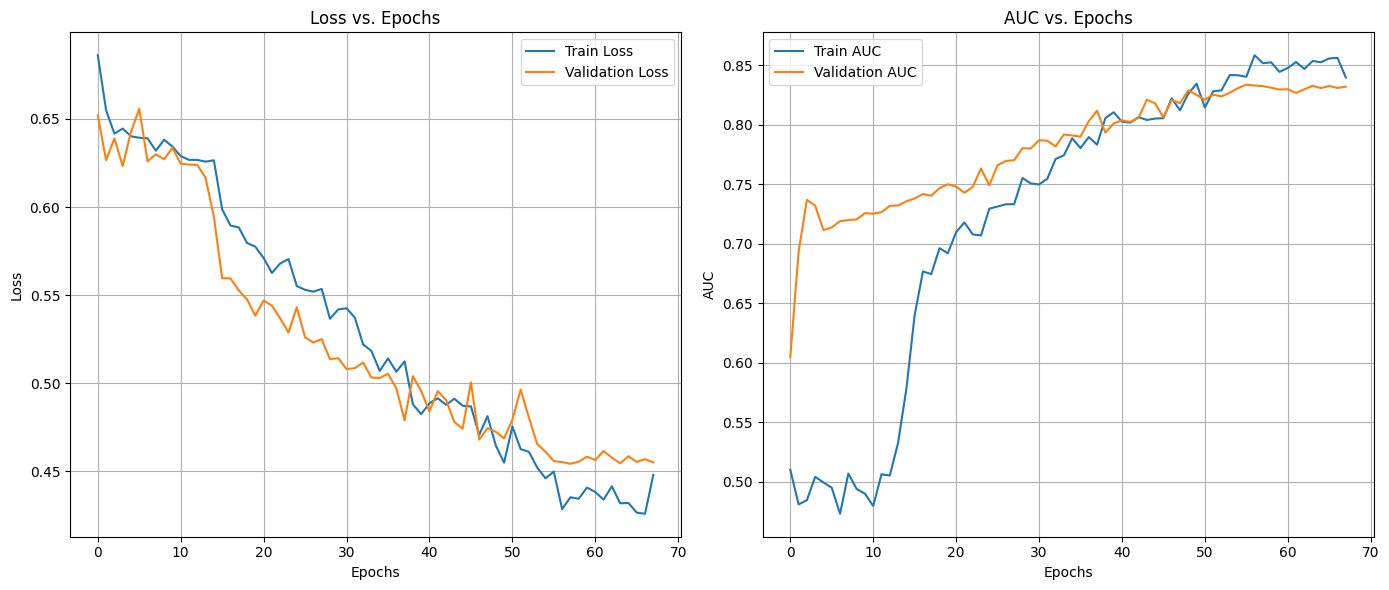

In [29]:
# ==============================================================================
# 5. Logging and Visualization of Results
# ==============================================================================
plt.figure(figsize=(14, 6))
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(history['train_auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [30]:
# ==============================================================================
# 7. Testing the Model on Unseen Data (with Sensitivity)
# ==============================================================================

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

# 7.1. Load Test Metadata
mass_test_df = pd.read_csv(os.path.join(config.CSV_PATH, 'mass_case_description_test_set.csv'))
calc_test_df = pd.read_csv(os.path.join(config.CSV_PATH, 'calc_case_description_test_set.csv'))
test_df = pd.concat([mass_test_df, calc_test_df], ignore_index=True)

# --- Apply SAME preprocessing pipeline as training/validation ---

def extract_simple_patient_id(pid):
    parts = pid.split('_')
    for i, part in enumerate(parts):
        if part == 'P':
            return f"{part}_{parts[i+1]}"
    return pid

test_df['simple_patient_id'] = test_df['patient_id'].apply(extract_simple_patient_id)
test_df['patient_breast_id'] = test_df['simple_patient_id'] + '_' + test_df['left or right breast']
test_df['label'] = test_df['pathology'].apply(lambda x: 1 if 'MALIGNANT' in x.upper() else 0)

# Map CSV paths to actual JPEGs
test_df['jpeg_path'] = find_jpeg_path(test_df['image file path'])

# Drop missing
original_rows = len(test_df)
test_df.dropna(subset=['jpeg_path'], inplace=True)
print(f"\nSuccessfully mapped {len(test_df)} of {original_rows} test CSV entries to JPEG files.")

# Pair CC/MLO views
paired_test_data = []
grouped = test_df.groupby('patient_breast_id')

for name, group in tqdm(grouped, desc="Pairing CC and MLO views (Test)"):
    cc_view = group[group['image view'] == 'CC']
    mlo_view = group[group['image view'] == 'MLO']

    if not cc_view.empty and not mlo_view.empty:
        for _, cc_row in cc_view.iterrows():
            for _, mlo_row in mlo_view.iterrows():
                paired_test_data.append({
                    'patient_breast_id': name,
                    'cc_path': cc_row['jpeg_path'],
                    'mlo_path': mlo_row['jpeg_path'],
                    'label': cc_row['label']
                })

paired_test_df = pd.DataFrame(paired_test_data)
print(f"\nSuccessfully created {len(paired_test_df)} CC/MLO pairs for Test set.")

# 7.2. Define Test Dataset & Loader
test_dataset = CBISDDSMDataset(paired_test_df, transform=val_transform)  # no augmentations
test_loader = DataLoader(
    test_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY
)

# 7.3. Load Best Model
model.load_state_dict(torch.load('mv_swin_t_best_model.pth', map_location=config.DEVICE))
model.to(config.DEVICE)
model.eval()

# 7.4. Evaluate on Test Set
all_preds, all_labels = [], []
test_loss = 0.0

with torch.inference_mode():  
    for batch in tqdm(test_loader, desc="Testing"):
        cc_view, mlo_view, labels = batch['cc_view'].to(config.DEVICE), batch['mlo_view'].to(config.DEVICE), batch['label'].to(config.DEVICE)
        outputs = model(cc_view, mlo_view)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        all_preds.append(torch.sigmoid(outputs).cpu())
        all_labels.append(labels.cpu())

# 7.5. Compute Metrics
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

binary_preds = (all_preds > 0.5).astype(int)

test_loss /= len(test_loader)
test_auc = roc_auc_score(all_labels, all_preds)
test_acc = accuracy_score(all_labels, binary_preds)

tn, fp, fn, tp = confusion_matrix(all_labels, binary_preds).ravel()
sensitivity = tp / (tp + fn + 1e-8)

print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test AUC: {test_auc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Sensitivity (Recall): {sensitivity:.4f}")


Mapping CSV to JPEG paths: 100%|██████████| 704/704 [00:00<00:00, 2900.32it/s]



Successfully mapped 704 of 704 test CSV entries to JPEG files.


Pairing CC and MLO views (Test): 100%|██████████| 369/369 [00:00<00:00, 1803.02it/s]



Successfully created 361 CC/MLO pairs for Test set.


Testing: 100%|██████████| 91/91 [02:08<00:00,  1.41s/it]


✅ Test Loss: 0.6592
✅ Test AUC: 0.6813
✅ Test Accuracy: 0.6704
✅ Test Sensitivity (Recall): 0.7462


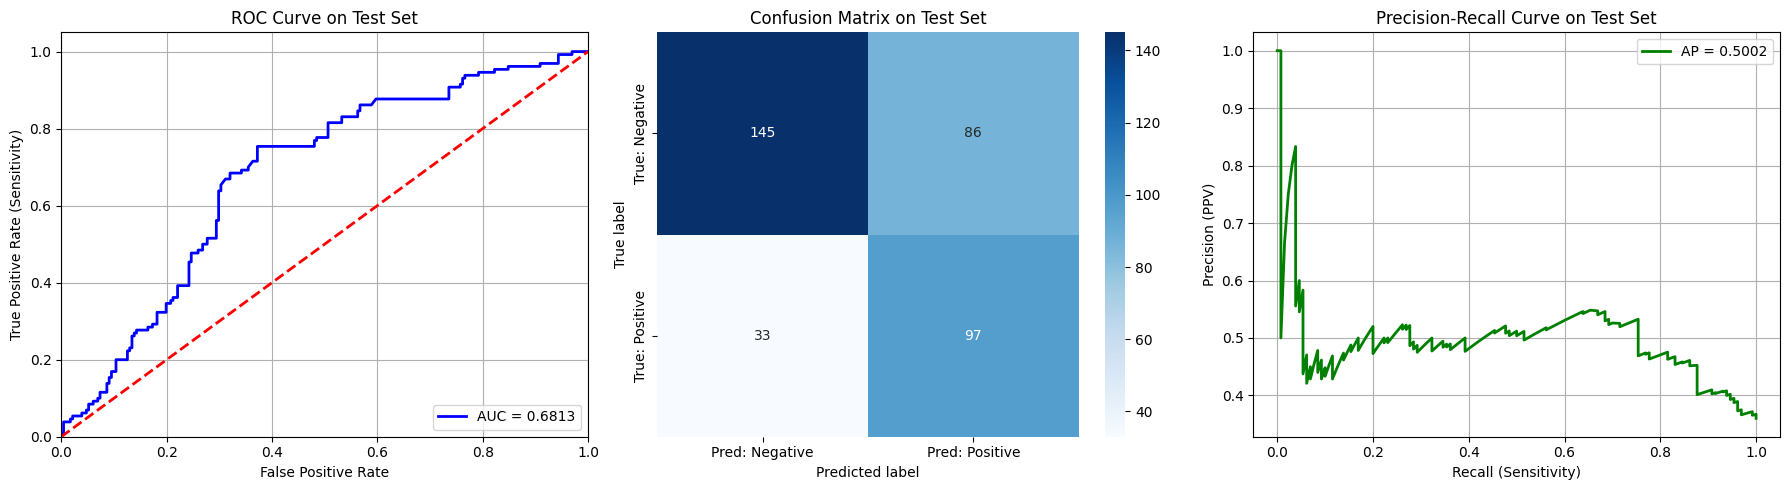

In [31]:
# ==============================================================================
# 8. Graphical Representation of Test Results
# ==============================================================================

from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- ROC Curve values ---
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# --- Precision-Recall values ---
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_preds)
ap_score = average_precision_score(all_labels, all_preds)

plt.figure(figsize=(18, 5))

# --- ROC Curve ---
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve on Test Set")
plt.legend(loc="lower right")
plt.grid(True)

# --- Confusion Matrix ---
plt.subplot(1, 3, 2)
cm = confusion_matrix(all_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Negative", "Pred: Positive"],
            yticklabels=["True: Negative", "True: Positive"])
plt.title("Confusion Matrix on Test Set")
plt.ylabel("True label")
plt.xlabel("Predicted label")

# --- Precision-Recall Curve ---
plt.subplot(1, 3, 3)
plt.plot(recall, precision, color="green", lw=2, label=f"AP = {ap_score:.4f}")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision-Recall Curve on Test Set")
plt.legend(loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================================
# 9. Saving Model Weights aswell as Model Architecture+Weight
# ==============================================================================
# Save both
# Save model weights only
torch.save(model.state_dict(), "breast_cancer_model_weights.pth")
# Later, load weights into the same model architecture
#model = YourModelClass()   # Replace with your CNN+MV SwinTransformer class
#model.load_state_dict(torch.load("breast_cancer_model_weights.pth"))
#model.to(device)
#model.eval()

# Save the entire model
torch.save(model, "breast_cancer_model_full.pth")
# Load entire model
#model = torch.load("breast_cancer_model_full.pth")
#model.to(device)
#model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843138..1.0].


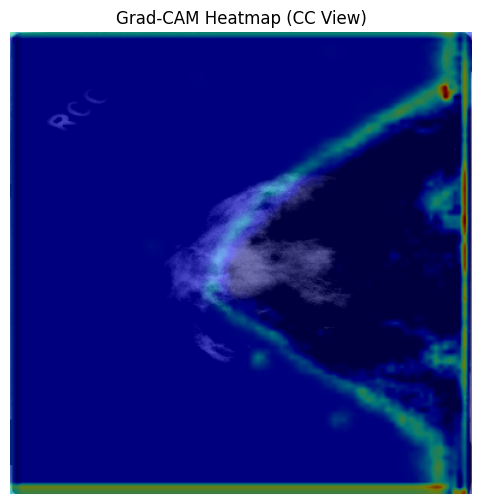

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843138..1.0].


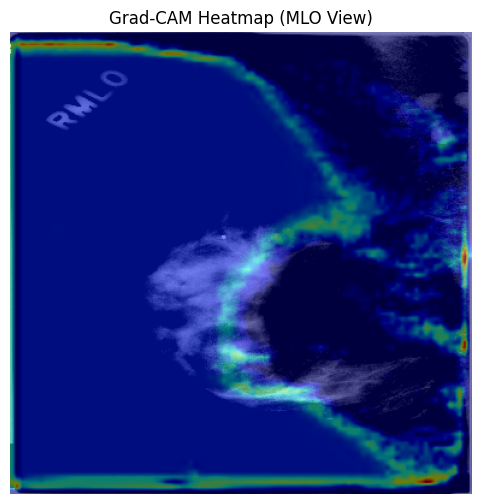

In [53]:
# ======================================================================
# 10. GRAD/CAM (Updated)
# ======================================================================
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

# ------------------ Grad-CAM Helper ------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, cc_tensor, mlo_tensor, target_class=0):
        """
        cc_tensor, mlo_tensor: shape (B, C, H, W)
        target_class: int (0 or 1 for binary classification)
        returns: CAM of shape (H, W)
        """
        self.model.eval()
        cc_tensor = cc_tensor.to(config.DEVICE)
        mlo_tensor = mlo_tensor.to(config.DEVICE)

        output = self.model(cc_tensor, mlo_tensor)

        # Pick scalar for backward
        output_scalar = output[:, target_class].sum()
        self.model.zero_grad()
        output_scalar.backward(retain_graph=True)

        # Grad-CAM computation
        # 1. Global average pooling over HxW
        weights = self.gradients.mean(dim=(2,3), keepdim=True)  # (B, C, 1, 1)

        # 2. Weighted sum of activations
        cam = (weights * self.activations).sum(dim=1)           # (B, H, W)

        # 3. ReLU and convert to numpy
        cam = F.relu(cam)
        cam = cam[0].cpu().numpy()                               # select first sample

        # 4. Resize to original image size
        cam = cv2.resize(cam, (config.IMG_SIZE, config.IMG_SIZE))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # normalize to [0,1]

        return cam


# ------------------ Hook Layers ------------------
target_layer_cc = model.cnn_frontend_cc.conv3
target_layer_mlo = model.cnn_frontend_mlo.conv3

gradcam_cc = GradCAM(model, target_layer_cc)
gradcam_mlo = GradCAM(model, target_layer_mlo)

# ------------------ Select One Test Sample ------------------
sample = next(iter(test_loader))
cc_view = sample['cc_view']  # (B, C, H, W)
mlo_view = sample['mlo_view']

# ------------------ Generate CAMs ------------------
cam_cc = gradcam_cc.generate_cam(cc_view, mlo_view)
cam_mlo = gradcam_mlo.generate_cam(cc_view, mlo_view)

# ------------------ Visualize CC View ------------------
plt.figure(figsize=(6,6))
plt.imshow(cc_view[3].permute(1,2,0).cpu().numpy(), cmap='gray')
plt.imshow(cam_cc, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Heatmap (CC View)")
plt.axis('off')
plt.show()

# ------------------ Visualize MLO View ------------------
plt.figure(figsize=(6,6))
plt.imshow(mlo_view[3].permute(1,2,0).cpu().numpy(), cmap='gray')
plt.imshow(cam_mlo, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Heatmap (MLO View)")
plt.axis('off')
plt.show()

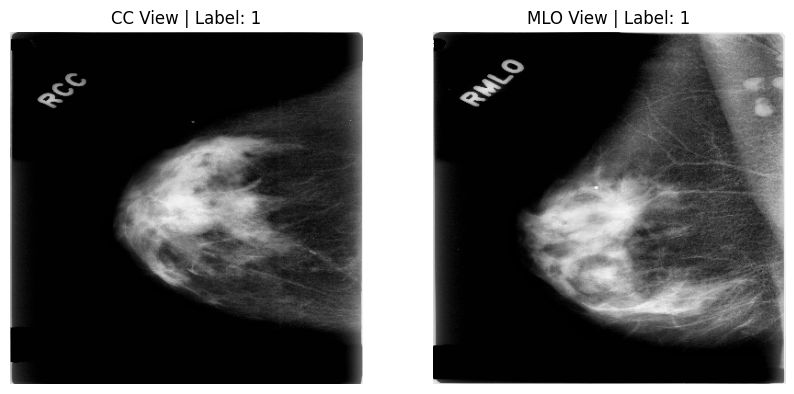

In [52]:
import matplotlib.pyplot as plt

# Get one batch
sample = next(iter(test_loader))
cc_view = sample['cc_view']  # (B, C, H, W)
mlo_view = sample['mlo_view']
labels = sample['label']

# Convert tensor to numpy image
def tensor_to_img(tensor):
    img = tensor.permute(1, 2, 0).cpu().numpy()  # CHW → HWC
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # normalize 0–1
    return img

# Show first pair (CC and MLO views)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(tensor_to_img(cc_view[3]))
axs[0].set_title(f"CC View | Label: {labels[3].item():.0f}")
axs[0].axis("off")

axs[1].imshow(tensor_to_img(mlo_view[3]))
axs[1].set_title(f"MLO View | Label: {labels[3].item():.0f}")
axs[1].axis("off")

plt.show()


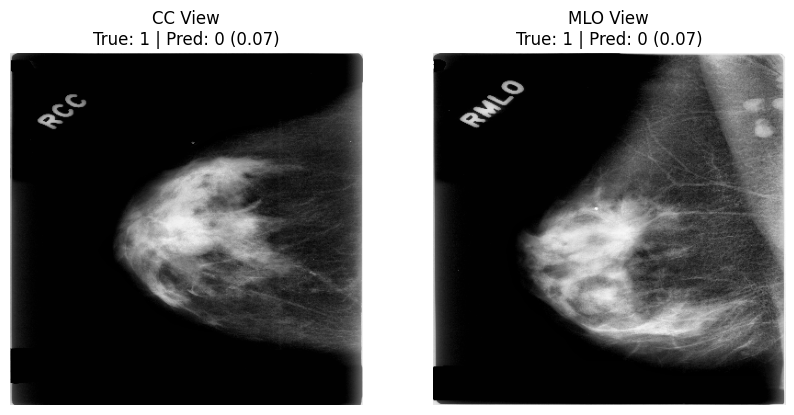

In [56]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Take one test sample
sample = next(iter(test_loader))

cc_view = sample['cc_view'].to(config.DEVICE)
mlo_view = sample['mlo_view'].to(config.DEVICE)
labels = sample['label']

# Run model prediction
model.eval()
with torch.no_grad():
    outputs = model(cc_view, mlo_view)
    probs = torch.sigmoid(outputs).cpu().numpy().squeeze()
    preds = (probs > 0.5).astype(int)

# Convert tensor → numpy image
def tensor_to_img(tensor):
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# Pick index = 1 (second sample in batch)
idx = 3
true_label = int(labels[idx].item())
pred_label = int(preds[idx])
pred_prob = probs[idx]

# Plot CC and MLO views
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(tensor_to_img(cc_view[idx].cpu()))
axs[0].set_title(f"CC View\nTrue: {true_label} | Pred: {pred_label} ({pred_prob:.2f})")
axs[0].axis("off")

axs[1].imshow(tensor_to_img(mlo_view[idx].cpu()))
axs[1].set_title(f"MLO View\nTrue: {true_label} | Pred: {pred_label} ({pred_prob:.2f})")
axs[1].axis("off")

plt.show()
